In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.analysis import circular_stats
import os 
seed = 2023

In [2]:
def moving_average(data:np.ndarray,win:int,step:int=1)-> np.ndarray:
    d_shape=data.shape
    count = 0
    if len(d_shape) == 3:
        d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
        for i_step in np.arange(0,d_shape[2]-win,step):
            d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
            count +=1
    if len(d_shape) == 2:
        d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
        for i_step in np.arange(0,d_shape[1]-win,step):
            d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
            count +=1
    if len(d_shape) == 1:
        d_avg = np.zeros((int(np.floor(d_shape[0]/step))))
        for i_step in np.arange(0,d_shape[0]-win,step):
            d_avg[count] = np.mean(data[i_step:i_step+win],axis=0)
            count +=1

    return d_avg

In [3]:
def get_task_variables(data:SpikeData,bhv:BhvData,in_out:str='in'):
    # Select trials (correct and DMTS task) and create task frame
    trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]

    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=bhv.condition[trial_idx],
        test_stimuli=bhv.test_stimuli[trial_idx],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    task = task[task['in_out']==in_out]
    return task, trial_idx

In [4]:
def get_trials_by_sample(task,feature,trial_idx,bhv,data):
    sample_trials = {"o1":np.array([]),"o5":np.array([]),"c1":np.array([]),"c5":np.array([])}
    
    for key_sample in sample_trials.keys():
        sample_trials[key_sample]=np.unique(task.loc[task['sample'].str.contains(key_sample, case=False)]['trial_idx'].values)

    test_stimuli = bhv.test_stimuli[trial_idx][sample_trials[feature]]
    code_numbers = data.code_numbers[trial_idx][sample_trials[feature]]
    code_samples = data.code_samples[trial_idx][sample_trials[feature]]
    sp_samples = data.sp_samples[trial_idx][sample_trials[feature]]
    return test_stimuli,code_numbers,code_samples,sp_samples,sample_trials

In [5]:
def delete_match(test_stimuli,code):
    code = (code-1).astype(int)
    tests_shape=test_stimuli.shape
    test_stimuli = np.concatenate([test_stimuli,np.ones((tests_shape[0],1))],axis=1)
    test_stimuli[np.arange(tests_shape[0]),code] =  np.nan
    test_stimuli = test_stimuli[:,:tests_shape[1]]
    return test_stimuli.astype(str)

In [6]:
def get_sample_avg_fr(task,sp_samples,test_stimuli,code_samples,color_orient:int=0):
    n_trials = np.zeros((8,4))
    samples_dicts = {"o1_c1":{},"o1_c5":{},"o5_c1":{},"o5_c5":{}}
    stim_num=['1','2','3','4','5','6','7','8']
    for i_sam,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
        task_sample = task[task['sample']==sample]
        test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
        # code_numbers_samp = code_numbers[task_sample['trial_idx']]
        code_samples_samp = code_samples[task_sample['trial_idx']]
        sp_samples_samp = sp_samples[task_sample['trial_idx']]

        test_stimuli_samp = delete_match(test_stimuli_samp)

        for i_num,i_stim in enumerate(stim_num):
            i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim)==color_orient)
            tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
            sp_stim = sp_samples_samp[i_trial]
            sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 100:400]
            if np.isnan(np.sum(sp_tests)):
                raise ValueError('nan values')
            samples_dicts[sample][i_stim] = sp_tests.mean(axis=1)*1000
            n_trials[i_num,i_sam] =sp_tests.shape[0]

    return samples_dicts,n_trials

In [7]:
def select_rand_trials_from_samples(sample1,sample2,samples_dicts,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]
    for n_it in range(n_iterations):
        np.random.seed(it_seed[n_it]) 
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr_s1 = np.random.choice(samples_dicts[sample1][i_stim], size=min_n_trials[i_num], replace=True, p=None)
            fr_s2 = np.random.choice(samples_dicts[sample2][i_stim], size=min_n_trials[i_num], replace=True, p=None)
            fr = np.concatenate([fr_s1,fr_s2])
            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

In [8]:
def get_null_vector_from_samples(sample1,sample2,samples_dicts,min_n_trials,seed:int=1,n_iterations:int=1000):
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=10000, size=n_iterations, dtype=int)
    stim_num=['1','2','3','4','5','6','7','8']
    stim_angle = np.array([0,45,90,135,180,225,270,315]) * np.pi/180
    mean_select=[]

     
    # all_sample1 = np.concatenate(list(samples_dicts[sample1].values()))
    # all_sample2 = np.concatenate(list(samples_dicts[sample2].values()))

    for n_it in range(n_iterations):
        all_sample1 = []
        all_sample2 = []
        np.random.seed(it_seed[n_it]) 
        for i_num,i_stim in enumerate(stim_num):
            all_sample1.append(np.random.choice(samples_dicts[sample1][i_stim], size=min_n_trials[i_num], replace=False, p=None))
            all_sample2.append(np.random.choice(samples_dicts[sample2][i_stim], size=min_n_trials[i_num], replace=False, p=None))
        all_sample1 = np.concatenate(all_sample1)
        all_sample2 = np.concatenate(all_sample2)  
        mean_resp = np.zeros((8,2))
        for i_num,i_stim in enumerate(stim_num):
            fr_s1 = np.random.choice(all_sample1, size=min_n_trials[i_num], replace=True, p=None)
            fr_s2 = np.random.choice(all_sample2, size=min_n_trials[i_num], replace=True, p=None)
            fr = np.concatenate([fr_s1,fr_s2])

            mean_resp[i_num] = circular_stats.mean_vector(fr, [stim_angle[i_num]]*len(fr))
        mean_select.append(circular_stats.mean_vector(mean_resp[:,0], mean_resp[:,1]) )
    mean_select=np.array(mean_select)
    return mean_select

### Compute

In [9]:
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_bhv_lip.txt", "r")
lines_bhv = file1.readlines()
file1 = open("/envau/work/invibe/USERS/IBOS/code/flow/paths_sp_lip.txt", "r")
lines_sp = file1.readlines()
# load all  files
paths_bhv,paths_sp=[],[]
for line in lines_bhv:
    paths_bhv.append(line.strip())
for line in lines_sp:
    paths_sp.append(line.strip())

### plots samples

In [10]:
orient = 0 
color = 1
n_iterations = 1000
win=100
step=1
samp_orient = (["o1_c1","o5_c1"],["o1_c5","o5_c5"])
samp_color = (["o1_c1","o1_c5"],["o5_c1","o5_c5"])

o_c = [color,color]
color_orient = color


In [61]:
paths_bhv[27:]

['/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-17_10-11-51_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-20_10-39-08_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-21_10-40-02_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-22_10-34-47_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-03-30_10-36-53_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-06_10-38-57_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-09_11-13-27_Riesling_e1_r1_bhv.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/bhv/2023-10-10_10-41-43_Riesling_e1_r1_bhv.h5']

In [ ]:
# Neurons I checked
# path: 2022-12-16_10-30-59 i_neuron:4

In [63]:
# definir dataframe y agregar neurona y p value para cada orientacion
selectivity_info: Dict[str, list] = defaultdict(list)

n_bhv=paths_bhv[27]
n_sp = paths_sp[27]
print(n_sp)
s_path = os.path.normpath(n_sp).split(os.sep)
date = s_path[-1][:19]
data = SpikeData.from_python_hdf5(n_sp)
bhv = BhvData.from_python_hdf5(n_bhv)

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-03-17_10-11-51_Riesling_lip_e1_r1_sp.h5


In [64]:
all_task, all_trial_idx = get_task_variables(data,bhv,in_out='in')

In [65]:
all_task.head()

,i_neuron,trial_idx,sample,in_out,n_test_stimuli,code
0,0,6,o0_c0,in,5,7
1,0,12,o1_c1,in,4,4
2,0,19,o1_c1,in,1,1
3,0,25,o1_c1,in,5,5
4,0,28,o1_c1,in,3,3


In [66]:
data.clustersgroup

array(['good', 'good', 'good', 'good', 'mua', 'good', 'mua', 'mua',
       'good', 'mua'], dtype='<U4')

In [67]:
i_neuron = 2

In [68]:
task_tr = np.unique(all_task['trial_idx'].values)
trial_idx = task_tr[np.nansum(data.sp_samples[all_trial_idx[task_tr],i_neuron],axis=1)>0]
task = all_task[np.in1d(all_task['trial_idx'] , trial_idx)]
task=task[task['i_neuron']==i_neuron]

test_stimuli = bhv.test_stimuli[all_trial_idx]
code_numbers = data.code_numbers[all_trial_idx]
code_samples = data.code_samples[all_trial_idx]
sp_samples = data.sp_samples[all_trial_idx,i_neuron]

### Plot response by samples

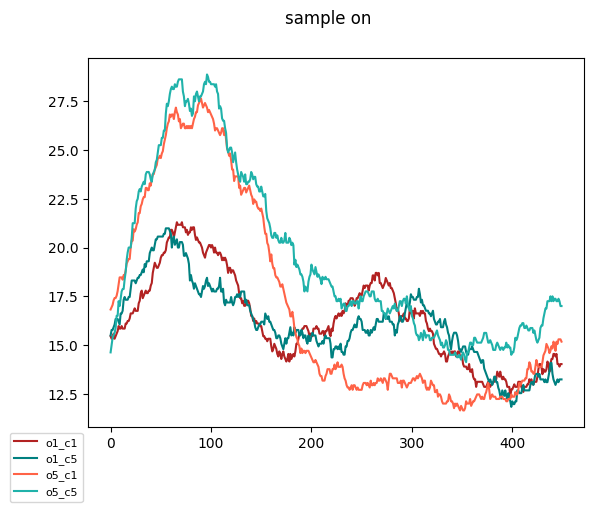

In [69]:
len_s_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_sample_on = np.zeros((4,len_s_on+win))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_s_on+win]
    all_sp_sample_on[i] = sp_sample_on.mean(axis=0)
fig,ax = plt.subplots()
for sample,sp_sample in zip(["o1_c1","o1_c5","o5_c1","o5_c5"],all_sp_sample_on):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:450],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('sample on')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})


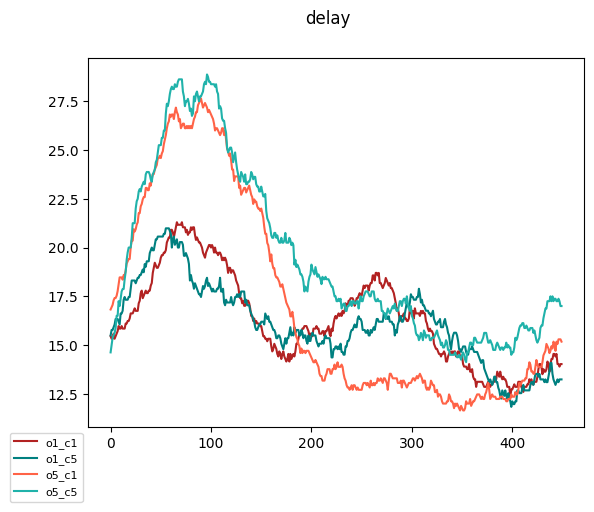

In [70]:
len_d_on=450
win=100
all_sp_delay = np.zeros((4,len_d_on+win))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_d_on+win]
    all_sp_delay[i] = sp_delay.mean(axis=0)

fig,ax = plt.subplots()
for sample,sp_sample in zip(["o1_c1","o1_c5","o5_c1","o5_c5"],all_sp_sample_on):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:450],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('delay')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

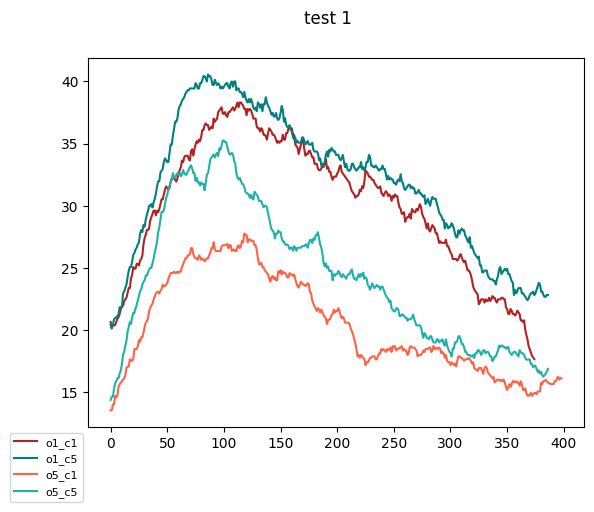

In [71]:
len_t1_on=450
win=100
all_sp_test1 = np.zeros((4,len_t1_on+win))
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_test1 = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,6].astype(int), axis=1)[:, :len_t1_on+win]
    all_sp_test1[i] = sp_test1.mean(axis=0)

fig,ax = plt.subplots()
for sample,sp_sample in zip(["o1_c1","o1_c5","o5_c1","o5_c5"],all_sp_test1):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:450],label=sample,color=task_constants.PALETTE_B1[sample])
fig.suptitle('test 1')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

### Plot response by feature (color 1, color 5, orientation 1, orientation 5)

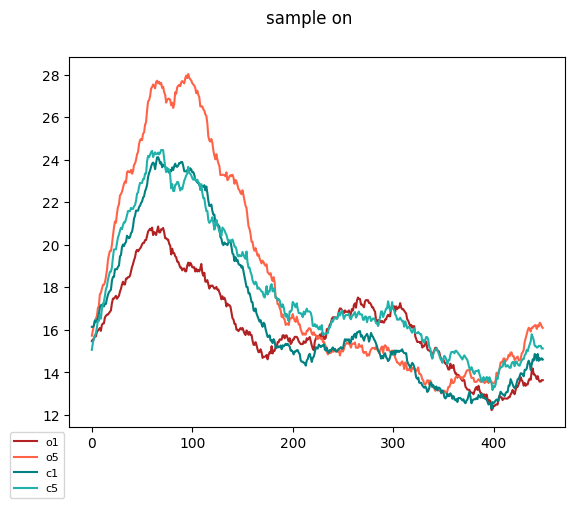

In [72]:
len_s_on=450
win=100
all_sp_sample_on = np.zeros((4,len_s_on+win))
all_feature_s_on_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_sample_on = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,4].astype(int), axis=1)[:, :len_s_on+win]
    all_sp_sample_on[i] = sp_sample_on.mean(axis=0)
o1 = np.mean([all_sp_sample_on[0],all_sp_sample_on[1]],axis=0)
o5 = np.mean([all_sp_sample_on[2],all_sp_sample_on[3]],axis=0)
c1 = np.mean([all_sp_sample_on[0],all_sp_sample_on[2]],axis=0)
c5 = np.mean([all_sp_sample_on[1],all_sp_sample_on[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:450],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_s_on_avg.append(sample_avg[:450])
fig.suptitle('sample on')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

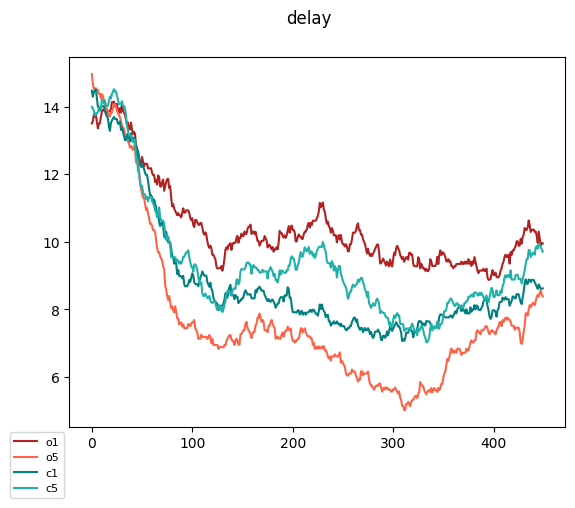

In [73]:
len_d_on=450
win=100
all_sp_delay = np.zeros((4,len_d_on+win))
all_feature_delay_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]

    sp_delay = SpikeData.indep_roll(sp_samples_samp, -code_samples_samp[:,5].astype(int), axis=1)[:, :len_d_on+win]
    all_sp_delay[i] = sp_delay.mean(axis=0)

o1 = np.mean([all_sp_delay[0],all_sp_delay[1]],axis=0)
o5 = np.mean([all_sp_delay[2],all_sp_delay[3]],axis=0)
c1 = np.mean([all_sp_delay[0],all_sp_delay[2]],axis=0)
c5 = np.mean([all_sp_delay[1],all_sp_delay[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_delay_avg.append(sample_avg[:len_d_on])
fig.suptitle('delay')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_35405/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


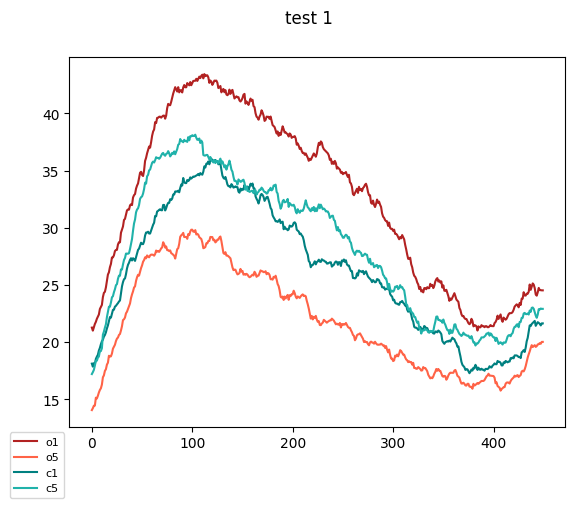

In [74]:
len_t1_on=450
win=100
all_sp_test1 = np.zeros((4,len_t1_on+win))
all_feature_t1_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,0]!='nan')[0]

    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,6].astype(int), axis=1)[:, :len_t1_on+win]
    all_sp_test1[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test1[0],all_sp_test1[1]],axis=0)
o5 = np.mean([all_sp_test1[2],all_sp_test1[3]],axis=0)
c1 = np.mean([all_sp_test1[0],all_sp_test1[2]],axis=0)
c5 = np.mean([all_sp_test1[1],all_sp_test1[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t1_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 1')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_35405/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


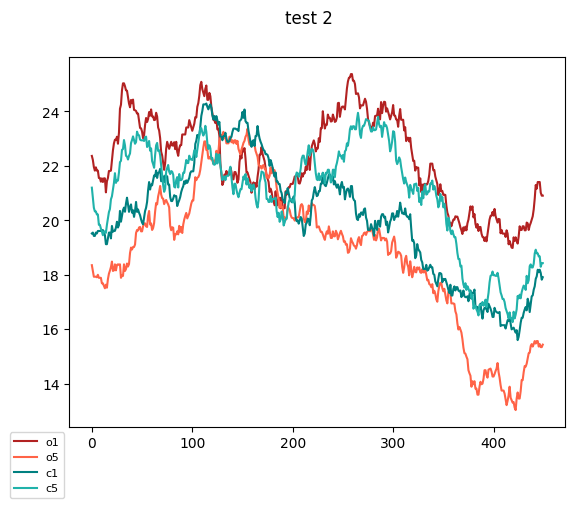

In [75]:
len_t2_on=450
win=100
all_sp_test2 = np.zeros((4,len_t2_on+win))
all_feature_t2_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,1]!='nan')[0]

    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,8].astype(int), axis=1)[:, :len_t2_on+win]

    all_sp_test2[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test2[0],all_sp_test2[1]],axis=0)
o5 = np.mean([all_sp_test2[2],all_sp_test2[3]],axis=0)
c1 = np.mean([all_sp_test2[0],all_sp_test2[2]],axis=0)
c5 = np.mean([all_sp_test2[1],all_sp_test2[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t2_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 2')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_35405/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


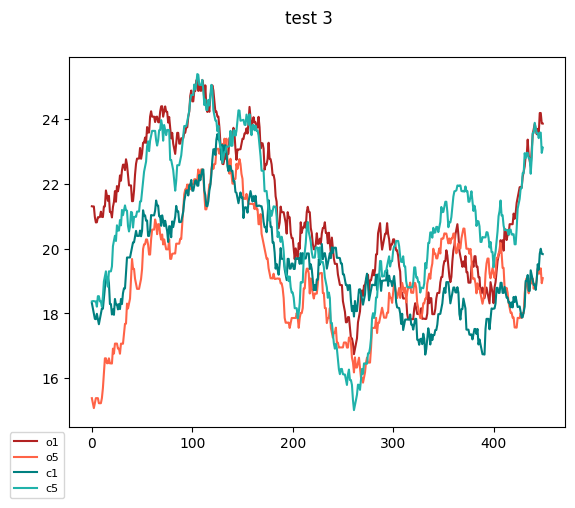

In [76]:
len_t2_on=450
win=100
all_sp_test2 = np.zeros((4,len_t2_on+win))
all_feature_t3_avg = []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,2]!='nan')[0]
    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,10].astype(int), axis=1)[:, :len_t2_on+win]    
    all_sp_test2[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test2[0],all_sp_test2[1]],axis=0)
o5 = np.mean([all_sp_test2[2],all_sp_test2[3]],axis=0)
c1 = np.mean([all_sp_test2[0],all_sp_test2[2]],axis=0)
c5 = np.mean([all_sp_test2[1],all_sp_test2[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t3_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 3')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_35405/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


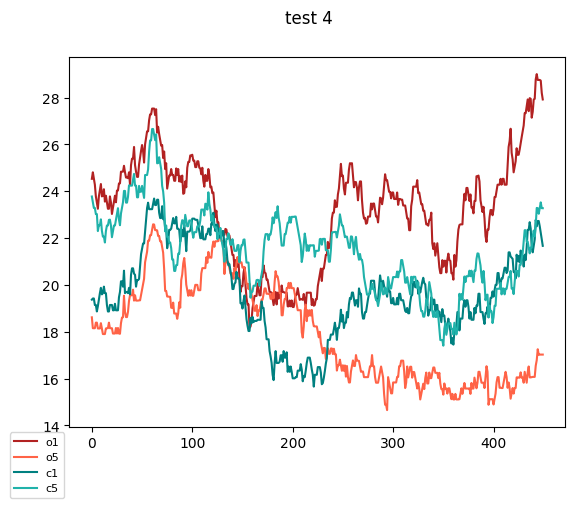

In [77]:
len_t2_on=450
win=100
all_sp_test2 = np.zeros((4,len_t2_on+win))
all_feature_t4_avg= []
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,3]!='nan')[0]
    
    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,12].astype(int), axis=1)[:, :len_t2_on+win]
    all_sp_test2[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test2[0],all_sp_test2[1]],axis=0)
o5 = np.mean([all_sp_test2[2],all_sp_test2[3]],axis=0)
c1 = np.mean([all_sp_test2[0],all_sp_test2[2]],axis=0)
c5 = np.mean([all_sp_test2[1],all_sp_test2[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t4_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 4')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

/tmp/ipykernel_35405/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


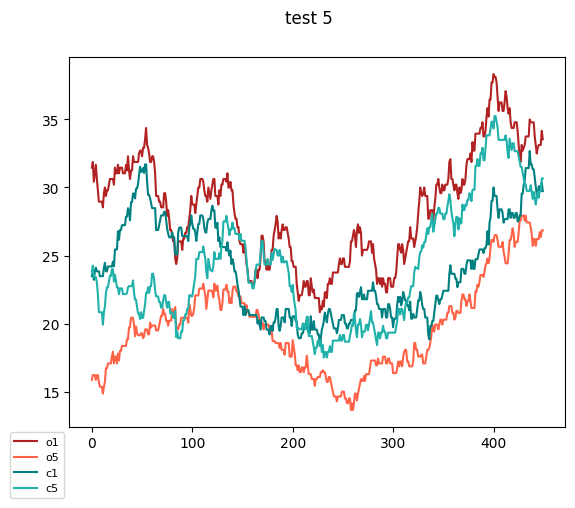

In [78]:
len_t2_on=450
win=100
all_sp_test2 = np.zeros((4,len_t2_on+win))
all_feature_t5_avg=[]
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):
    task_sample = task[task['sample']==sample]
    test_stimuli_samp = test_stimuli[task_sample['trial_idx']]
    code_numbers_samp = code_numbers[task_sample['trial_idx']]
    code_samples_samp = code_samples[task_sample['trial_idx']]
    sp_samples_samp = sp_samples[task_sample['trial_idx']]
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)
    idx = np.where(test_stimuli_samp[:,4]!='nan')[0]
    
    sp_test1 = SpikeData.indep_roll(sp_samples_samp[idx], -code_samples_samp[idx,14].astype(int), axis=1)[:, :len_t2_on+win]
    all_sp_test2[i] = sp_test1.mean(axis=0)

o1 = np.mean([all_sp_test2[0],all_sp_test2[1]],axis=0)
o5 = np.mean([all_sp_test2[2],all_sp_test2[3]],axis=0)
c1 = np.mean([all_sp_test2[0],all_sp_test2[2]],axis=0)
c5 = np.mean([all_sp_test2[1],all_sp_test2[3]],axis=0)

fig,ax = plt.subplots()
for i,(sample,sp_sample) in enumerate(zip(["o1_c1","o5_c1","o1_c5","o5_c5"],[o1,o5,c1,c5])):
    sample_avg = moving_average(data=sp_sample,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample])
    all_feature_t5_avg.append(sample_avg[:len_d_on])
fig.suptitle('test 5')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

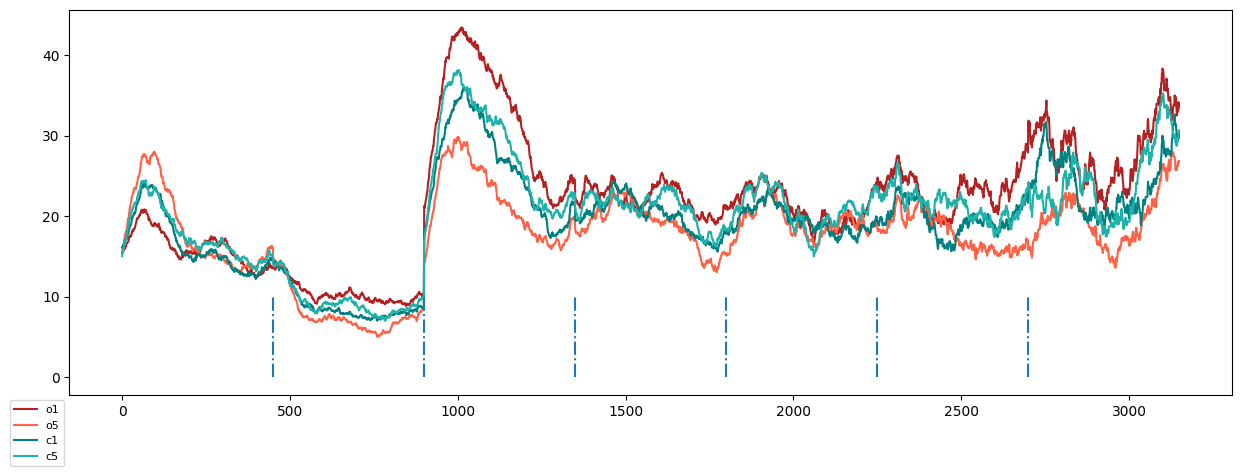

In [79]:
all_trial = np.concatenate([all_feature_s_on_avg,all_feature_delay_avg,all_feature_t1_avg,all_feature_t2_avg,all_feature_t3_avg,all_feature_t4_avg,all_feature_t5_avg],axis=1)
sample=["o1_c1","o5_c1","o1_c5","o5_c5"]
fig,ax=plt.subplots(figsize=(15,5))
for i in range(4):
    ax.plot(all_trial[i],label=['o1','o5','c1','c5'][i],color=task_constants.PALETTE_B1[sample[i]])
ax.vlines([450,450*2,450*3,450*4,450*5,450*6],[0,0,0,0,0,0],[10,10,10,10,10,10],linestyles='-.')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})

## ff

In [80]:
def get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient,stim_num):
    all_sp_tests=[]
    for i_num,i_stim in enumerate(stim_num):
        i_trial, i_test = np.where(np.char.find(test_stimuli_samp,i_stim)==color_orient)
        tests_on = code_samples_samp[i_trial,2*i_test+6].astype(int)
        sp_stim = sp_samples_samp[i_trial]
        sp_tests = SpikeData.indep_roll(sp_stim, -tests_on, axis=1)[:, 0:550]
        if np.isnan(np.sum(sp_tests)):
            raise ValueError('nan values')
        all_sp_tests.append(sp_tests)
    return all_sp_tests

In [81]:
len_t1_on=450
win=100
stim_num=['1','2','3','4','5','6','7','8']
all_sp_test1 = np.zeros((4,len_t1_on+win))

all_sample_feature = {"o1_c1":{"color":[],"orientation":[]},"o1_c5":{"color":[],"orientation":[]},"o5_c1":{"color":[],"orientation":[]},"o5_c5":{"color":[],"orientation":[]}}
for i,sample in enumerate(["o1_c1","o1_c5","o5_c1","o5_c5"]):

    
    task_sample = task[task['sample']==sample]
    trials = task_sample['trial_idx'].values
    test_stimuli_samp = test_stimuli[trials]
    code_numbers_samp = code_numbers[trials]
    code_samples_samp = code_samples[trials]
    sp_samples_samp = sp_samples[trials]
    
    code = task_sample['code'].values
    test_stimuli_samp = delete_match(test_stimuli_samp,code)

    color_tests = get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient=color,stim_num=stim_num)
    orient_tests = get_sp_feature(sp_samples_samp,test_stimuli_samp,code_samples_samp,color_orient=orient,stim_num=stim_num)

    all_sample_feature[sample]["color"]= color_tests
    all_sample_feature[sample]["orientation"]= orient_tests

/tmp/ipykernel_35405/3123404539.py:7: RuntimeWarning: invalid value encountered in cast
  return test_stimuli.astype(str)


In [82]:
o1 = []
o5 = []
c1 = []
c5 = []
for i in range(8):
    o1.append(np.concatenate([all_sample_feature["o1_c1"]['orientation'][i],all_sample_feature["o1_c5"]['orientation'][i]],axis=0))
    print("o1 - o%d n trials: %d"%(i,o1[i].shape[0]))
    o5.append(np.concatenate([all_sample_feature["o5_c1"]['orientation'][i],all_sample_feature["o5_c5"]['orientation'][i]],axis=0))
    print("o5 - o%d n trials: %d"%(i,o5[i].shape[0]))
    c1.append(np.concatenate([all_sample_feature["o1_c1"]['color'][i],all_sample_feature["o5_c1"]['color'][i]],axis=0))
    print("c1 - c%d n trials: %d"%(i,c1[i].shape[0]))
    c5.append(np.concatenate([all_sample_feature["o1_c5"]['color'][i],all_sample_feature["o5_c5"]['color'][i]],axis=0))
    print("c5 - c%d n trials: %d"%(i,c5[i].shape[0]))

o1 - o0 n trials: 85
o5 - o0 n trials: 66
c1 - c0 n trials: 96
c5 - c0 n trials: 47
o1 - o1 n trials: 30
o5 - o1 n trials: 42
c1 - c1 n trials: 28
c5 - c1 n trials: 19
o1 - o2 n trials: 25
o5 - o2 n trials: 26
c1 - c2 n trials: 29
c5 - c2 n trials: 23
o1 - o3 n trials: 33
o5 - o3 n trials: 34
c1 - c3 n trials: 20
c5 - c3 n trials: 11
o1 - o4 n trials: 62
o5 - o4 n trials: 108
c1 - c4 n trials: 35
c5 - c4 n trials: 87
o1 - o5 n trials: 24
o5 - o5 n trials: 18
c1 - c5 n trials: 36
c5 - c5 n trials: 27
o1 - o6 n trials: 18
o5 - o6 n trials: 35
c1 - c6 n trials: 28
c5 - c6 n trials: 32
o1 - o7 n trials: 27
o5 - o7 n trials: 33
c1 - c7 n trials: 31
c5 - c7 n trials: 29


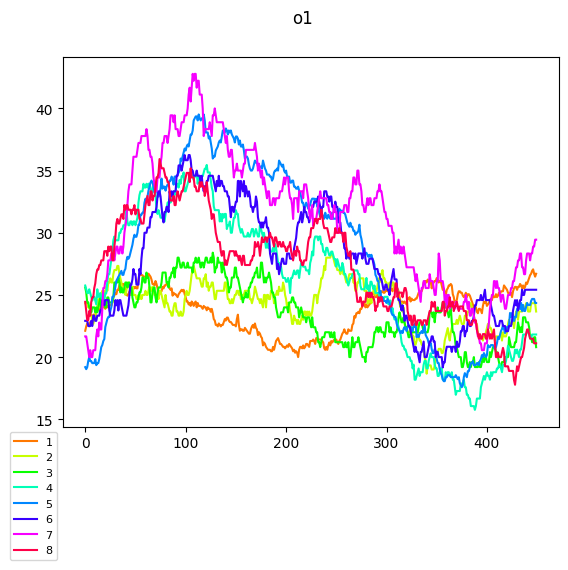

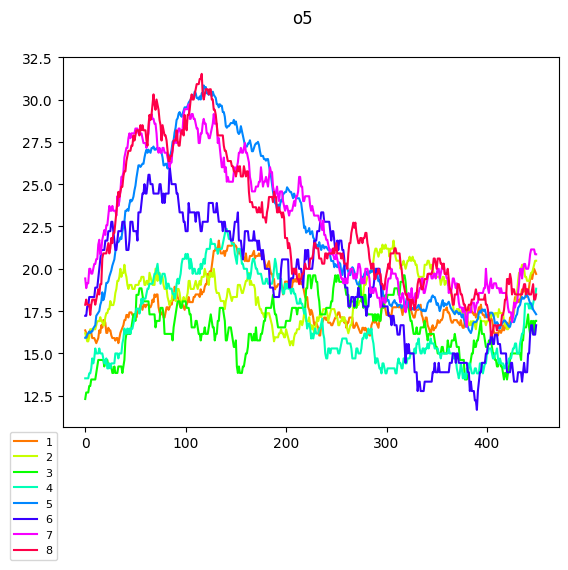

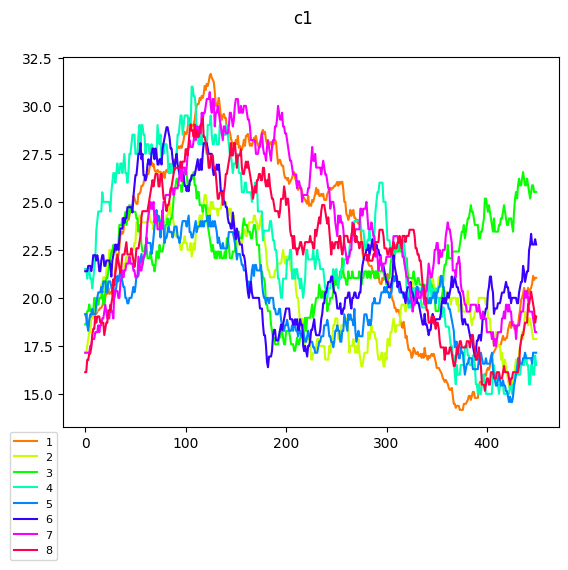

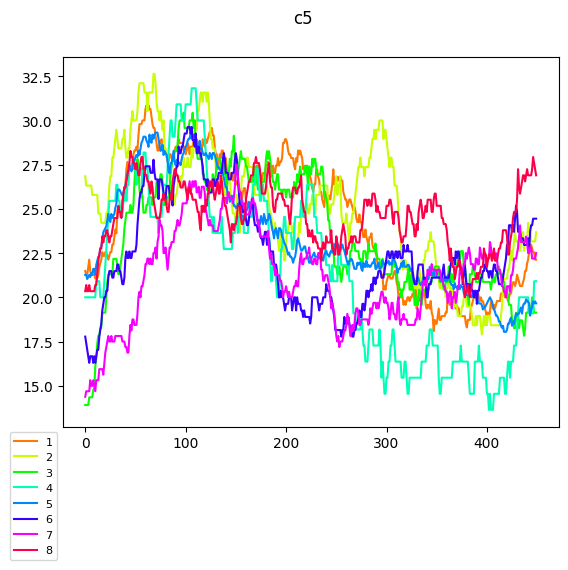

In [83]:
palette = plt.get_cmap('hsv',64)

fig,ax = plt.subplots()
for i, o_i in enumerate(o1):
    o_i = o_i.mean(axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('o1')
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})
fig,ax = plt.subplots()
for i, o_i in enumerate(o5):
    o_i = o_i.mean(axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('o5')
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})
fig,ax = plt.subplots()
for i, o_i in enumerate(c1):
    o_i = o_i.mean(axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('c1')
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})
fig,ax = plt.subplots()
for i, o_i in enumerate(c5):
    o_i = o_i.mean(axis=0)
    sample_avg = moving_average(data=o_i,win=win,step=1)*1000
    ax.plot(sample_avg[:len_d_on],label=stim_num[i],color=palette(i*8+5))
    fig.suptitle('c5')
    plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})